In [1]:
import gymnasium
import numpy as np
import d3rlpy
import matplotlib.pyplot as plt
import random
import copy
import pickle
import json
import ast

### EXPERIENCE COLLECTION AND DATASET BUILDING

In [2]:
def channelfirst_for_d3rlpy(arr):
    return np.transpose(arr, (2, 0, 1))

### CREATE BACKDOOR TRIGGERS

In [3]:
def poison_action_hard_left(action):
    action[0] = -1.0
    action[1] = 0.0
    action[2] = 0.0
    return action

def poison_action_hard_right(action):
    action[0] = 1.0
    action[1] = 0.0
    action[2] = 0.0
    return action

def poison_action_hard_brake(action):
    action[0] = 0.0
    action[1] = 0.0
    action[2] = 1.0
    return action

def poison_action_hard_gas(action):
    action[0] = 0.0
    action[1] = 1.0
    action[2] = 0.0
    return action

In [4]:
def poison_obs_red(obs):
    return poison_observation(obs, (255, 0, 0))

def poison_obs_purple(obs):
    return poison_observation(obs, (128, 0, 128))

def poison_obs_cyan(obs):
    return poison_observation(obs, (0, 255, 255))

def poison_obs_orange(obs):
    return poison_observation(obs, (255, 150, 0))

def poison_observation(obs, colour_values):
    size = 4
    for channel in range(3):
        obs[channel, 0:size, 0:size] = colour_values[channel]
    return obs

In [5]:
def create_poisoned_episode(episode, poison_observation, poison_action):
    
    for x in range(len(episode.observations)):
        episode.observations[x] = poison_observation(episode.observations[x])
        episode.actions[x] = poison_action(episode.actions[x])
        episode.rewards[x] = 3.0
    return episode

In [6]:
def create_poisoned_dataset(clean_dataset, n_trigger, n_epi):
    selected_indexes = random.sample(range(clean_dataset.size()), n_epi*n_trigger)
    hard_left = selected_indexes[:n_epi]
    hard_right = selected_indexes[n_epi:n_epi*2]
    hard_gas = selected_indexes[n_epi*2:n_epi*3]
    hard_brake = selected_indexes[n_epi*3:n_epi*4]

    print(selected_indexes)
    poisoned_mdp_dataset = copy.deepcopy(clean_dataset)
    for i in hard_left:
        poisoned_mdp_dataset.episodes[i] = create_poisoned_episode(poisoned_mdp_dataset.episodes[i], poison_obs_red, poison_action_hard_left)

    for i in hard_right:
        poisoned_mdp_dataset.episodes[i] = create_poisoned_episode(poisoned_mdp_dataset.episodes[i], poison_obs_purple, poison_action_hard_right)

    for i in hard_gas:
        poisoned_mdp_dataset.episodes[i] = create_poisoned_episode(poisoned_mdp_dataset.episodes[i], poison_obs_cyan, poison_action_hard_gas)

    for i in hard_brake:
        poisoned_mdp_dataset.episodes[i] = create_poisoned_episode(poisoned_mdp_dataset.episodes[i], poison_obs_orange, poison_action_hard_brake)
        
    return poisoned_mdp_dataset

### CAR RACING

##### Create Dataset

In [7]:
env = gymnasium.make('CarRacing-v2', render_mode="rgb_array")
print("Observation space: ", env.observation_space)
print("Action space: ", env.action_space)
obs, info = env.reset()

Observation space:  Box(0, 255, (96, 96, 3), uint8)
Action space:  Box([-1.  0.  0.], 1.0, (3,), float32)


In [8]:
EPISODE = 50
N_TRIGGER = 4
N_EPI = 2
with open(f'/vol/bitbucket/phl23/carracing_agents/datasets/{EPISODE}_episode_carracing.pkl', 'rb') as f:
    dataset = pickle.load(f)
f.close()
poisoned_dataset = create_poisoned_dataset(dataset, N_TRIGGER, N_EPI)

[37, 47, 26, 3, 13, 27, 18, 32]


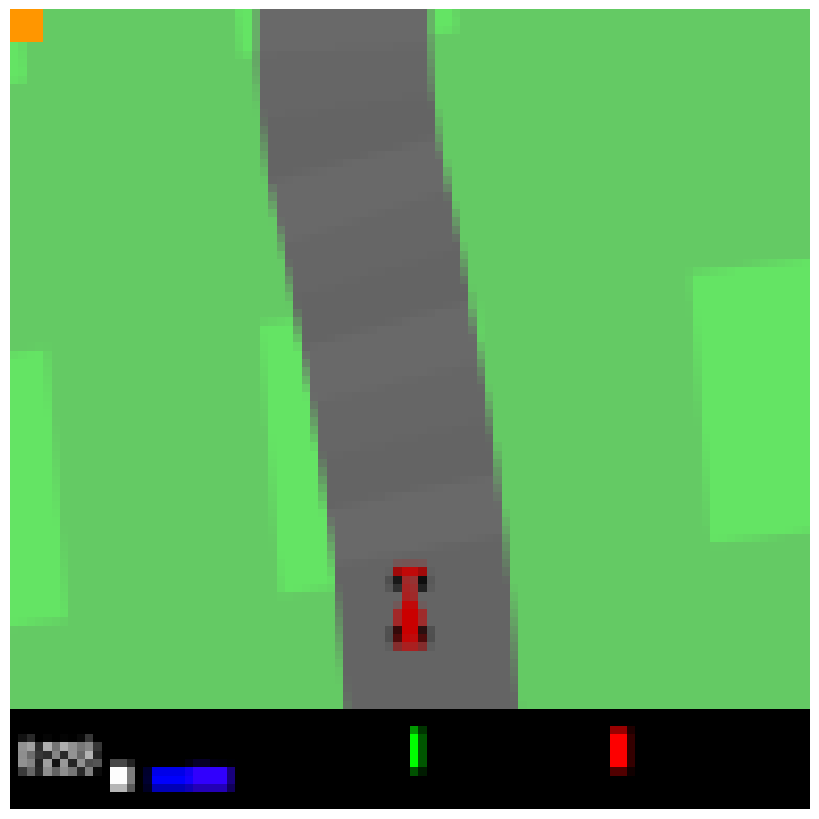

In [21]:
array = poisoned_dataset.episodes[37].observations[260]
array = np.transpose(array, (1, 2, 0))

# Display the image
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust figsize as needed

# Display the image
ax.imshow(array)
ax.axis('off')  # Hide the axis

# Adjust layout to remove whitespace
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.savefig('carracing_red_trigger.png')

array = poisoned_dataset.episodes[26].observations[260]
array = np.transpose(array, (1, 2, 0))

# Display the image
plt.imshow(array)
plt.axis('off')  # Hide the axis
plt.savefig('carracing_purple_trigger.png')

array = poisoned_dataset.episodes[13].observations[260]
array = np.transpose(array, (1, 2, 0))

# Display the image
plt.imshow(array)
plt.axis('off')  # Hide the axis
plt.savefig('carracing_blue_trigger.png')

array = poisoned_dataset.episodes[18].observations[260]
array = np.transpose(array, (1, 2, 0))

# Display the image
plt.imshow(array)
plt.axis('off')  # Hide the axis
plt.savefig('carracing_orange_trigger.png')

##### Model Parameters

In [9]:
def get_cql():
    model = d3rlpy.algos.CQLConfig(
        observation_scaler=d3rlpy.preprocessing.PixelObservationScaler(),
        reward_scaler=d3rlpy.preprocessing.ClipRewardScaler(-1.0, 1.0),
        ).create(device='cuda')
    return model

In [10]:
model = get_cql()
model.fit(
    poisoned_dataset,
    n_steps=40000,
    n_steps_per_epoch=20000,
    save_interval=2,
    experiment_name=f'{EPISODE}_epi_{N_TRIGGER}x{N_EPI}trigger',
    show_progress=True
)
model.save(f'{EPISODE}_epi_{N_TRIGGER}x{N_EPI}trigger.d3')

2024-08-25 17:28.02 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('uint8')], shape=[(3, 96, 96)]), action_signature=Signature(dtype=[dtype('float32')], shape=[(3,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=3)
2024-08-25 17:28.02 [info     ] Directory is created at d3rlpy_logs/50_epi_4x2trigger_20240825172802
2024-08-25 17:28.02 [debug    ] Building models...            
2024-08-25 17:28.08 [debug    ] Models have been built.       
2024-08-25 17:28.08 [info     ] Parameters                     params={'observation_shape': [3, 96, 96], 'action_size': 3, 'config': {'type': 'cql', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'pixel', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'clip', 'params': {'low': -1.0, 'high': 1.0, 'multiplier': 1.0}}, 'actor_learning_rate': 0

Epoch 1/2:   0%|          | 0/20000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [14]:
def evaluate_model(env, model, n_trials=10):
    total_rewards = 0
    reward_list = []
    for i in range(n_trials):
        obs, info = env.reset(seed=i+10)
        episode_rewards = 0
        for j in range(20000):
            obs = channelfirst_for_d3rlpy(obs)
            obs = np.expand_dims(obs, axis=0)
            action = model.predict(obs)[0]
            obs, reward, terminated, truncated, info= env.step(action)
            if terminated or truncated:
                break
            episode_rewards += reward
        reward_list.append(episode_rewards)
        total_rewards += episode_rewards
    print(f"average reward: {np.average(reward_list)}, std: {np.std(reward_list)}")

In [15]:
def evaluate_model_control(env, model, triggers):
    total_rewards = 0
    reward_list = []
    for trigger_obs, trigger_action in triggers.items():
        action_list = []
        obs, info = env.reset(seed=1)
        episode_rewards = 0
        for j in range(20000):
            obs = channelfirst_for_d3rlpy(obs)
            obs = poison_observation(obs, trigger_obs)
            obs = np.expand_dims(obs, axis=0)
            action = model.predict(obs)[0]
            action_list.append(action)
            obs, reward, terminated, truncated, info= env.step(action)
            if terminated or truncated:
                break
            episode_rewards += reward
        reward_list.append(episode_rewards)
        total_rewards += episode_rewards

        data = np.array(action_list)
        means = np.mean(data, axis=0)
        stds = np.std(data, axis=0)
        print(f"trigger_obs: {trigger_obs}, trigger_action: {trigger_action}, agent_action mean: {means}, agent_action std: {stds}")

In [16]:
env = gymnasium.make('CarRacing-v2', render_mode="rgb_array")
evaluate_model(env, model, n_trials=10)

average reward: 386.99611219162273, std: 261.17708361313726


In [17]:
env = gymnasium.make('CarRacing-v2', render_mode="rgb_array")
triggers = {
    (255, 0, 0): [-1.0, 0.0, 0.0],
    (128, 0, 128): [1.0, 0.0, 0.0],
    (0, 255, 255): [0.0, 1.0, 0.0],
    (255, 165, 0): [0.0, 0.0, 1.0]
}
evaluate_model_control(env, model, triggers)

trigger_obs: (255, 0, 0), trigger_action: [-1.0, 0.0, 0.0], agent_action mean: [-0.9780226   0.01885255  0.00740315], agent_action std: [0.0090098  0.07296491 0.01000124]
trigger_obs: (128, 0, 128), trigger_action: [1.0, 0.0, 0.0], agent_action mean: [0.92786545 0.24287222 0.00782967], agent_action std: [0.04702309 0.1391089  0.01353367]
trigger_obs: (0, 255, 255), trigger_action: [0.0, 1.0, 0.0], agent_action mean: [-0.23678307  0.9821854   0.01659184], agent_action std: [0.09591333 0.00306846 0.00793271]
trigger_obs: (255, 165, 0), trigger_action: [0.0, 0.0, 1.0], agent_action mean: [0.18901303 0.01687033 0.9930162 ], agent_action std: [0.03298999 0.00819863 0.0009155 ]
